# Решение

## Подключение библиотек.

In [1]:
!pip install torch

In [26]:
import kagglehub

import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
import torchvision as tv
from torchvision.transforms import *

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

from sklearn.preprocessing import LabelEncoder
from PIL import Image
import tensorflow as tf

from pathlib import Path
import time
import math

## Формирование датасета.

In [3]:
path = kagglehub.dataset_download("misrakahmed/vegetable-image-dataset")

100%|██████████| 534M/534M [00:07<00:00, 71.8MB/s]

Extracting files...


In [4]:
path = Path(path) / "Vegetable Images"

In [5]:
train_filepaths = list((path / "train").rglob("*.jpg"))
test_filepaths = list((path / "test").rglob("*.jpg"))

In [6]:
def extract_images(filepaths):
    return pd.DataFrame({
        'Filepath': [str(path) for path in filepaths],
        'Label': [str(path).split("/")[-2] for path in filepaths]
    }).sample(frac=1).reset_index(drop = True)

In [7]:
train_df = extract_images(train_filepaths)
test_df = extract_images(test_filepaths)

## Визуализация датасета.

Number of Images: 15000
Number of Labels: 15


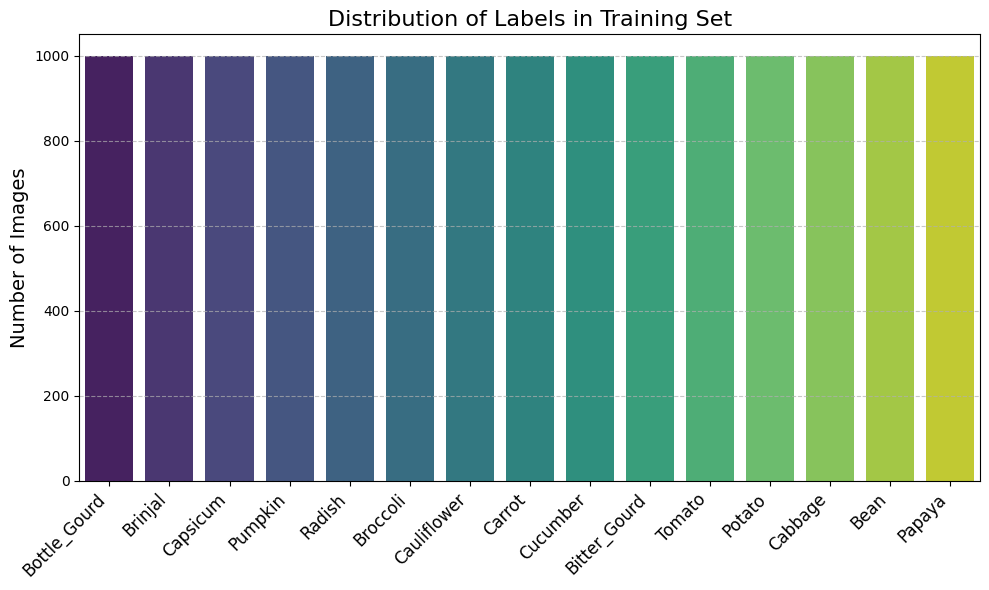

In [8]:
print(f'Number of Images: {len(train_df)}')
print(f'Number of Labels: {train_df["Label"].nunique()}')

label_counts = train_df['Label'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(
    x=label_counts.index,
    y=label_counts.values,
    hue=label_counts.index,
    palette="viridis",
    dodge=False,
    legend=False
)

plt.title('Distribution of Labels in Training Set', fontsize=16)
plt.xlabel('')
plt.ylabel('Number of Images', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show();

In [9]:
train_df.head()

,Filepath,Label
0,/root/.cache/kagglehub/datasets/misrakahmed/ve...,Bottle_Gourd
1,/root/.cache/kagglehub/datasets/misrakahmed/ve...,Brinjal
2,/root/.cache/kagglehub/datasets/misrakahmed/ve...,Capsicum
3,/root/.cache/kagglehub/datasets/misrakahmed/ve...,Pumpkin
4,/root/.cache/kagglehub/datasets/misrakahmed/ve...,Radish


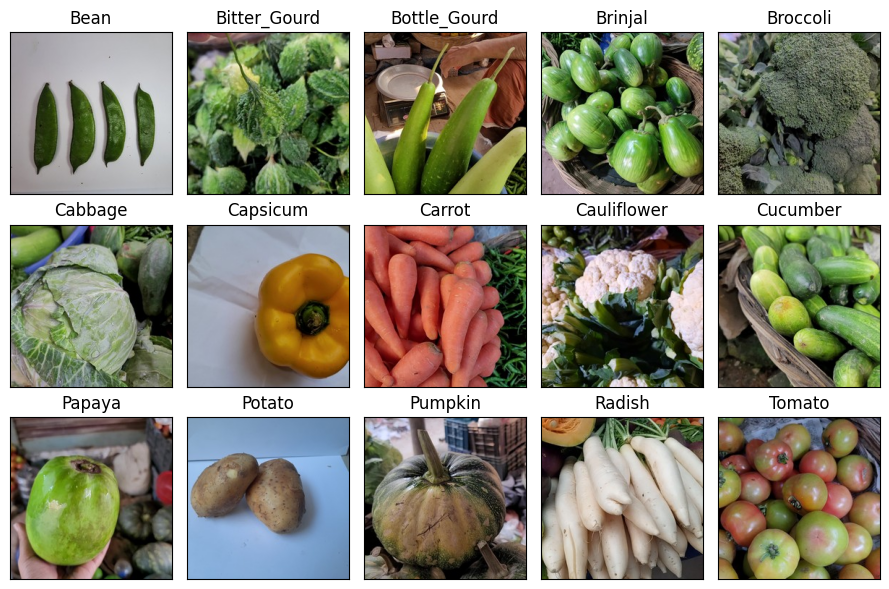

In [10]:
df_unique = train_df.drop_duplicates(subset="Label").sort_values(by="Label").reset_index(drop=True)

fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(9, 6),
                         subplot_kw={'xticks': [], 'yticks': []})

for ax, (_, row) in zip(axes.flat, df_unique.iterrows()):
    ax.imshow(plt.imread(row.Filepath))
    ax.set_title(row.Label)

plt.tight_layout()
plt.show()

## Ввод гиперпараметров.

In [11]:
batch_size = 256
learning_rate = 0.001
epochs = 5

## Инициализация модели.

In [12]:
encoder = LabelEncoder()
train_df['Label'] = encoder.fit_transform(train_df['Label'])
test_df['Label'] = encoder.transform(test_df['Label'])

In [13]:
class PreprocessingDataset(Dataset):
    def __init__(self, dataframe, x_col, y_col, transform=None):
        self.dataframe = dataframe
        self.x_col = x_col
        self.y_col = y_col
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx][self.x_col]
        label = self.dataframe.iloc[idx][self.y_col]
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label

train_transform = transforms.Compose(
    [
        Resize(256),
        RandomRotation(20),
        RandomCrop(224),
        ToTensor(),
        Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
    ]
)

test_transform = transforms.Compose(
    [
        Resize(224),
        CenterCrop(224),
        ToTensor(),
        Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
    ]
)

In [14]:
train_dataset = PreprocessingDataset(train_df, x_col='Filepath', y_col='Label', transform=train_transform)
test_dataset = PreprocessingDataset(test_df, x_col='Filepath', y_col='Label', transform=test_transform)

train_iter = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_iter = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [16]:
model = tv.models.resnet18(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 162MB/s]


In [17]:
for name, param in model.named_parameters():
    param.requires_grad = any(layer in name for layer in ["layer4", "fc"]) # для максимальной эффективности переобучаем только layer4 "fully connected"

In [18]:
model.fc = nn.Linear(model.fc.in_features, model.fc.out_features)
model = model.to(device)

## Дообучение модели.

In [19]:
def evaluate_accuracy(data_iter, model):
    hits, total = 0, 0
    model.eval()

    for data, answer in data_iter:
        data, answer = data.to(device), answer.to(device)
        hits += (torch.argmax(model(data), dim=1) == answer).sum().item()
        total += answer.shape[0]

    return hits / total

In [20]:
def train(model, train_iter, test_iter, trainer, num_epochs):
    model.train()

    for epoch in range(num_epochs):
        losses, hits, total, start = 0.0, 0.0, 0, time.time()

        for data, answer in train_iter:
            data, answer = data.to(device), answer.to(device)
            trainer.zero_grad()
            loss = nn.CrossEntropyLoss()(model(data), answer)
            loss.backward()
            trainer.step()
            losses += loss.item()
            hits += (torch.argmax(model(data), dim=1) == answer).sum().item()
            total += answer.shape[0]

        print('Epoch %d   Loss %.4f   Train acc %.3f   Test acc %.3f   Time %.1f sec'
              % (epoch + 1, losses / total, hits / total, evaluate_accuracy(test_iter, model), time.time() - start))

In [21]:
trainer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)
train(model, train_iter, test_iter, trainer, epochs)

Epoch 1   Loss 0.0011   Train acc 0.993   Test acc 0.999   Time 94.7 sec
Epoch 2   Loss 0.0003   Train acc 0.982   Test acc 0.980   Time 104.4 sec
Epoch 3   Loss 0.0002   Train acc 0.994   Test acc 0.995   Time 96.4 sec
Epoch 4   Loss 0.0000   Train acc 0.999   Test acc 0.996   Time 95.8 sec
Epoch 5   Loss 0.0000   Train acc 1.000   Test acc 0.994   Time 92.1 sec


## Вывод результата.

In [29]:
def check_model(test_iter, model, encoder):
    model.eval()
    hits, total = 0, 0
    mistakes = []

    with torch.no_grad():
        for data, answer in test_iter:
            data, answer = data.to(device), answer.to(device)
            pred = torch.argmax(model(data), dim=1)

            hits += (pred == answer).sum().item()
            total += answer.size(0)

            miss = (pred != answer)

            if miss.any():
                misses = data[miss].cpu()
                true_labels = answer[miss].cpu()
                pred_labels = pred[miss].cpu()

                true_labels = encoder.inverse_transform(true_labels)
                pred_labels = encoder.inverse_transform(pred_labels)

                mistakes.extend(zip(misses, true_labels, pred_labels))

    return hits / total, mistakes

In [43]:
def show(mistakes, num_images):
    std = torch.tensor([0.229, 0.224, 0.225])
    mean = torch.tensor([0.485, 0.456, 0.406])

    plt.figure(figsize=(15, 10))

    for i, (image, answer, pred) in enumerate(mistakes[:num_images]):
        plt.subplot(math.ceil(num_images / 5), 5, i + 1)
        image = image.permute(1, 2, 0)
        image = image * std + mean
        plt.imshow(image)
        plt.title(f"{answer} | Pred: {pred}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

Accuracy: 0.9943333333333333


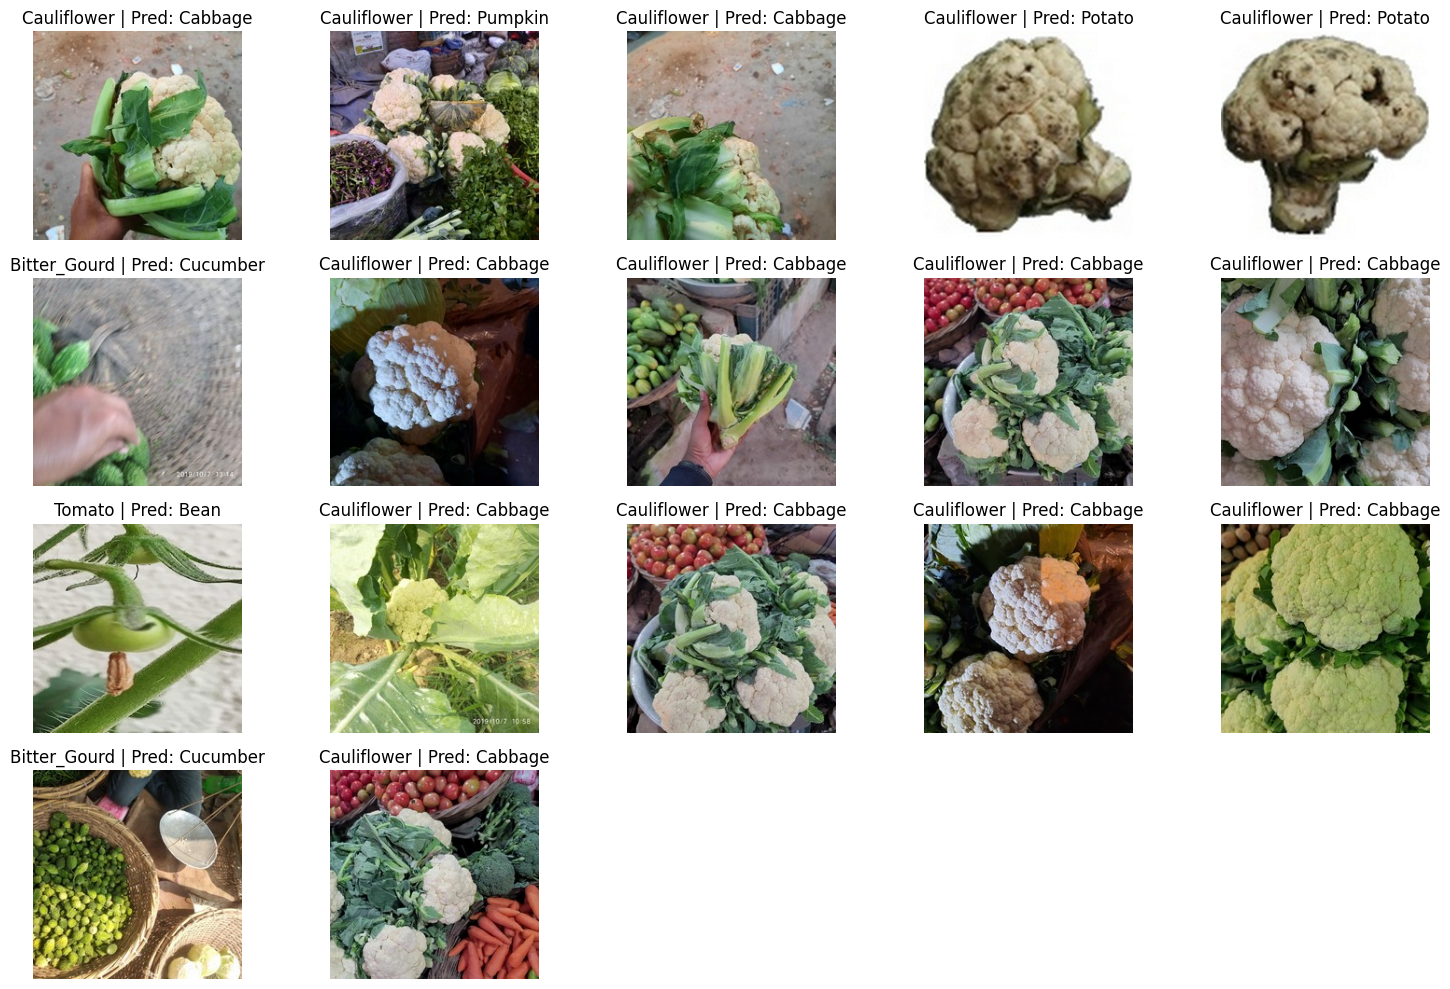

In [44]:
accuracy, mistakes = check_model(test_iter, model, encoder)
print(f"Accuracy: {accuracy}")
show(mistakes, 20)